In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import os

import torch
torch.manual_seed(42)
import torch.nn as nn

import itertools

from scipy import stats

HoursDay = 24
Hour_values = ['00:00', '01:00', '02:00', '03:00',
       '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00',
       '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00',
       '20:00', '21:00', '22:00', '23:00']

from google.colab import drive
drive.mount('/content/drive')

save_dir = "/content/drive/My Drive/Colab Notebooks/A5_GANS/Shared folder/"
os.makedirs(save_dir, exist_ok=True)

read_dir_GANS = save_dir
read_dir_DPM = save_dir

read_dir = save_dir
file_paths = [
    os.path.join(read_dir, 'France (FR)2022.csv')
    #os.path.join(read_dir, 'France (FR)2023.csv')
    #os.path.join(read_dir, 'France (FR)2024.csv')
]

data_frames = []

for file_path in file_paths:
    data_frames.append(pd.read_csv(file_path, sep=","))

data = pd.concat(data_frames, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(data.head())

Mounted at /content/drive
    Date(UTC) AreaDisplayName   00:00   01:00   02:00   03:00   04:00   05:00  \
0  2022-01-01     France (FR)   78.48   85.16   50.00   37.67   39.70   40.59   
1  2022-01-02     France (FR)   52.59   48.97   34.94   29.56   33.97   34.52   
2  2022-01-03     France (FR)    1.71    1.24    0.06    0.09    1.44   41.11   
3  2022-01-04     France (FR)  115.55  113.29  105.81  105.00  115.11  156.91   
4  2022-01-05     France (FR)  105.10   84.50   75.38   79.11   94.79  169.04   

    06:00   07:00  ...   14:00   15:00   16:00   17:00   18:00   19:00  \
0   43.26   49.66  ...   98.52  114.50  149.97  146.33  140.28  121.88   
1   41.80   48.95  ...   39.30   40.79   47.91   65.09   67.85   62.22   
2   90.54  161.79  ...  112.87  126.80  148.49  175.06  180.00  146.43   
3  182.64  178.91  ...  180.93  166.69  189.88  184.94  178.99  156.12   
4  215.98  211.13  ...  200.00  206.07  242.10  265.00  265.00  241.93   

    20:00   21:00   22:00   23:00  
0  102

In [ ]:
Initial_data = data[Hour_values].to_numpy()

def normalize_column_minmax(column):
    min_price = column.min()
    max_price = column.max()
    normalized_column = (column - min_price) / (max_price - min_price)

    # Store normalization parameters
    normalization_params_minmax[column.name] = {'min_price': min_price, 'max_price': max_price}

    return normalized_column

# Dictionary to store normalization parameters
normalization_params_minmax = {}

normalized_data_minmax = data[Hour_values].apply(normalize_column_minmax, axis=0)

normalization_params__minmax_df = pd.DataFrame.from_dict(normalization_params_minmax, orient='index')

data_normalized_minmax = data.copy()
data_normalized_minmax[Hour_values] = normalized_data_minmax

Training_data_GANS = data_normalized_minmax[Hour_values].to_numpy()
print('Training_data_GANS.shape ', Training_data_GANS.shape)

Training_data_GANS.shape  (365, 24)


In [ ]:
#######----------------------------------- LOAD GANS MODEL -----------------------------------#######
#######----------------------------------- LOAD GANS MODEL -----------------------------------#######
#######----------------------------------- LOAD GANS MODEL -----------------------------------#######

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Sigmoid()  # To generate [0,1]--normalized data
        )
    def forward(self, z):
        return self.model(z)

# Hyperparameters
latent_dim = 100 # Size of random noise vector
input_dim = 24 # 24-hour prices for a day

generator = Generator(latent_dim, HoursDay)
generator_save_path = os.path.join(read_dir_GANS, "generator.pth")

# Load the saved model weights
generator.load_state_dict(torch.load(generator_save_path))
# Set the model to evaluation mode
generator.eval()

# Confirm the model is loaded
print("Generator model loaded successfully!")
print(generator)

<ipython-input-5-02cfc9932a34>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_save_path))


Generator model loaded successfully!
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=24, bias=True)
    (5): Sigmoid()
  )
)


In [ ]:
noise = torch.randn(Training_data_GANS.shape[0], latent_dim)
fake_data_GANS = generator(noise)

def denormalize_array_minmax(normalized_array, normalization_params):
    denormalized_array = np.zeros_like(normalized_array)

    hour_keys = sorted(normalization_params.keys())

    for hour_idx, hour_key in enumerate(hour_keys):
        min_price = normalization_params[hour_key]['min_price']
        max_price = normalization_params[hour_key]['max_price']

        denormalized_array[:, hour_idx] = normalized_array[:, hour_idx] * (max_price - min_price) + min_price

    return denormalized_array, hour_keys

denormalized_array, hour_keys = denormalize_array_minmax(np.array(fake_data_GANS.detach()), normalization_params_minmax)
data_fake_GANS = pd.DataFrame(data=denormalized_array, columns=hour_keys)

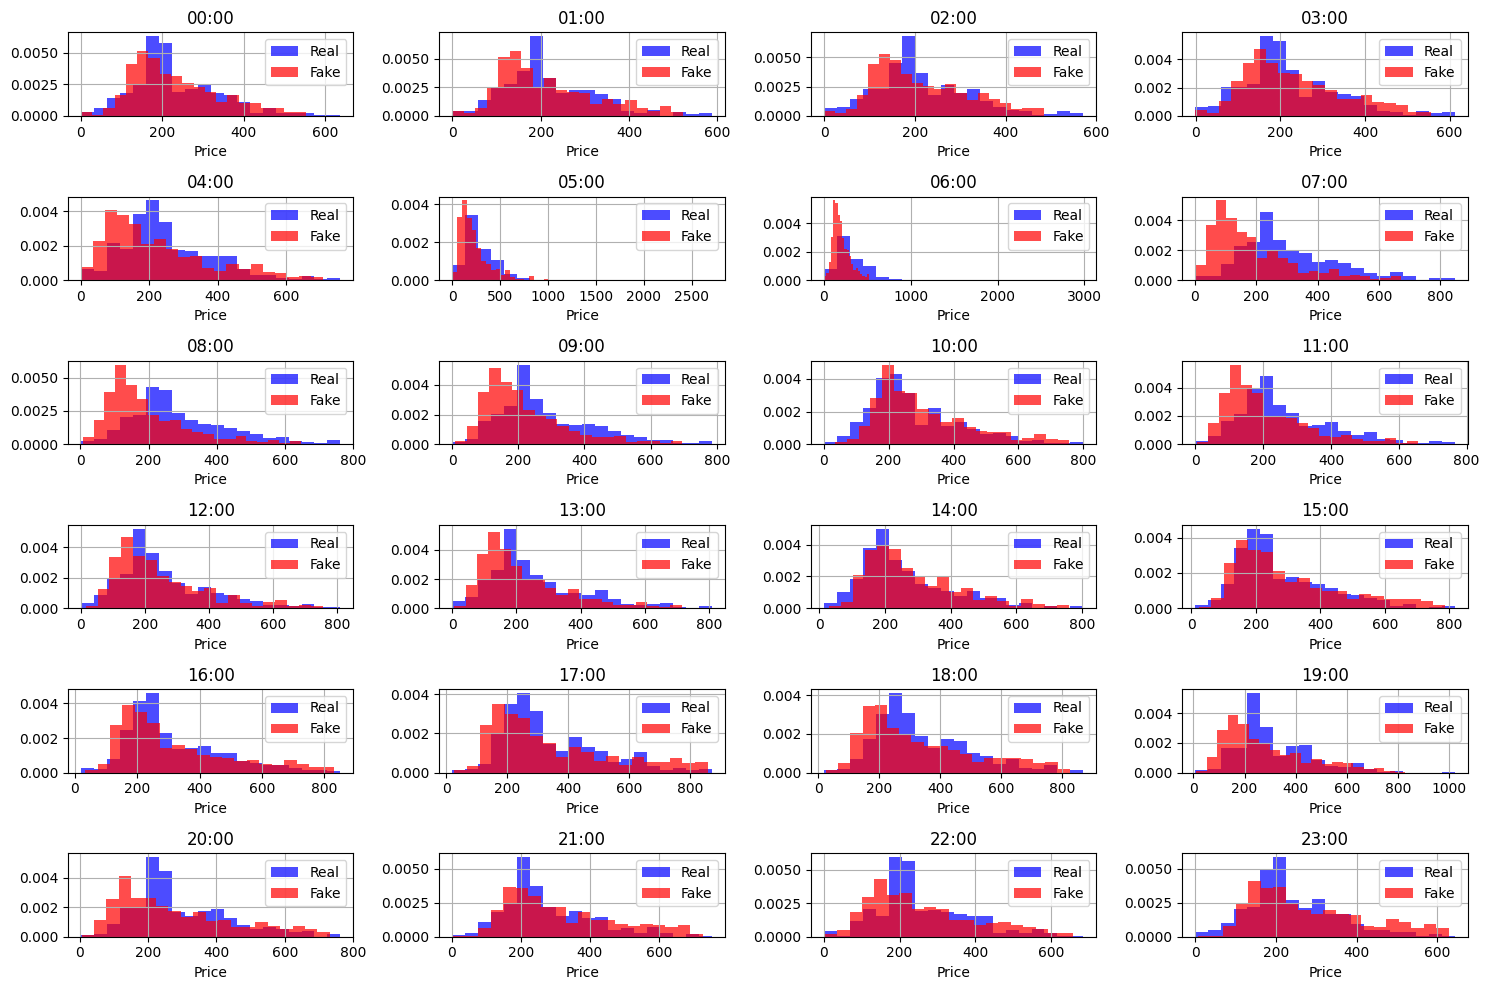

In [ ]:
# Create subplots
fig, axes = plt.subplots(6, 4, figsize=(15, 10))
axes = axes.flatten()

# Plot histograms for each hour
for idx in range(HoursDay):
    # Real Data
    subset1 = data[Hour_values[idx]]
    ax = axes[idx]
    ax.hist(subset1, bins=20, alpha=0.7, density=True, color='blue', label='Real')

    # Fake Data
    subset2 = data_fake_GANS[Hour_values[idx]]
    ax.hist(subset2, bins=20, alpha=0.7, density=True, color='red', label='Fake')

    # Set titles and labels
    ax.set_title(f'{Hour_values[idx]}')
    ax.set_xlabel('Price')
    ax.grid(True)
    ax.legend()

# Remove any unused subplots
for ax in axes[HoursDay:]:
    fig.delaxes(ax)

# Adjust layout
plt.tight_layout()

plt.savefig(os.path.join(save_dir, "GANS_FR2022"), dpi=300, transparent=True)  # 300 DPI and transparent

# Show the plot
plt.show()

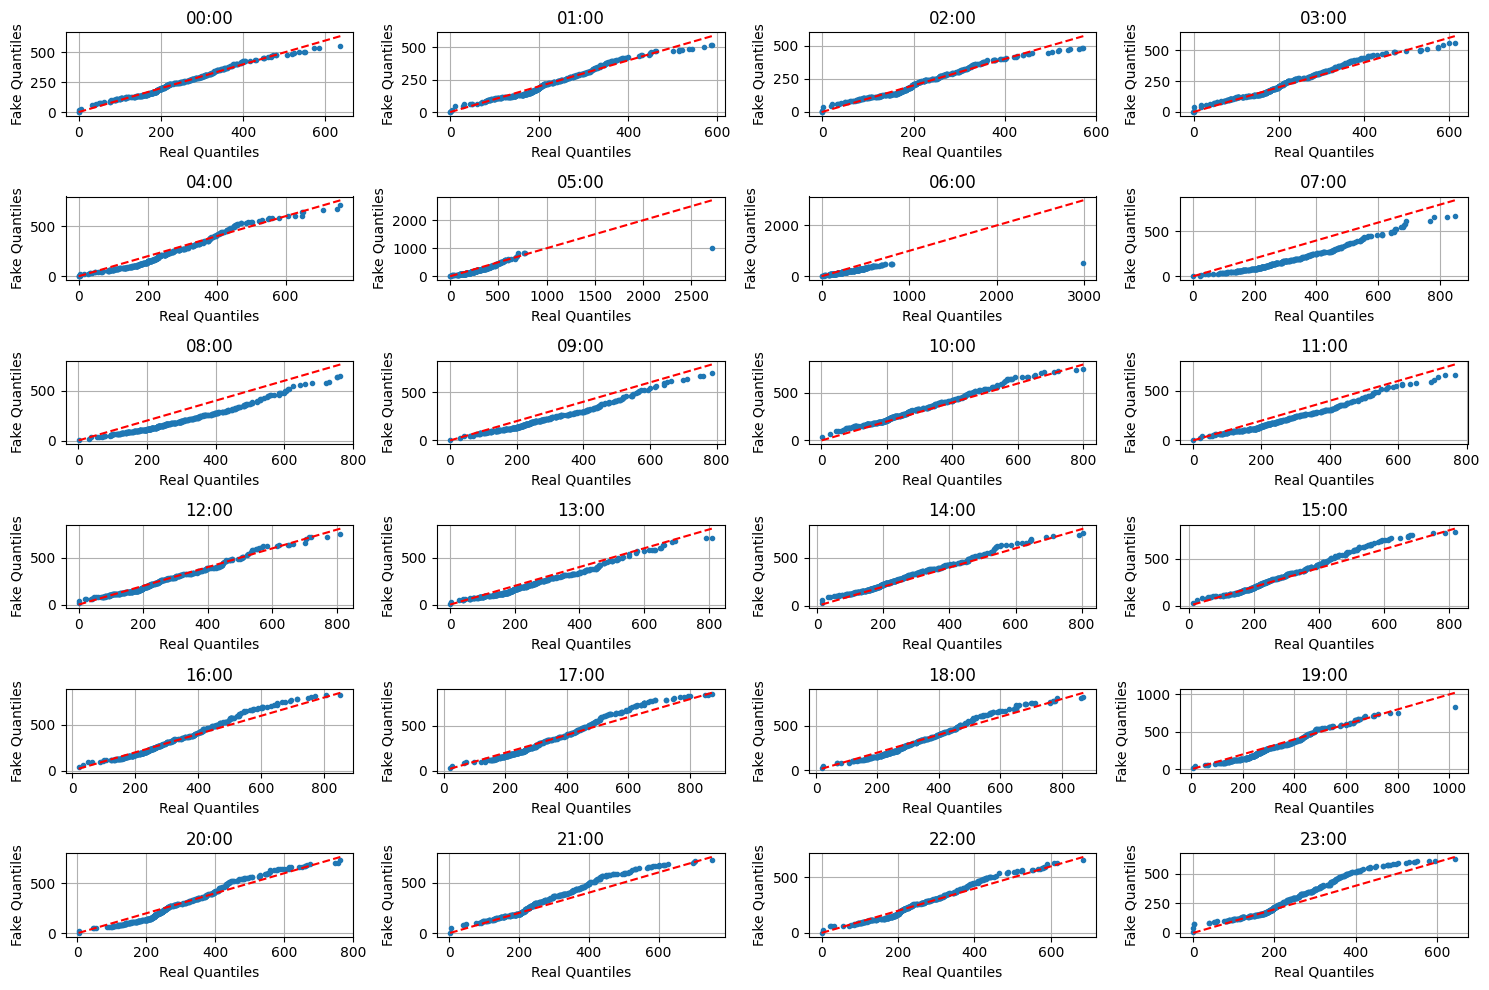

In [ ]:
# Create subplots
fig, axes = plt.subplots(6, 4, figsize=(15, 10))
axes = axes.flatten()

# Plot Q-Q plots for each hour
for idx in range(HoursDay):
    # Real Data
    subset1 = np.sort(data[Hour_values[idx]].to_numpy())
    # Fake Data
    subset2 = np.sort(data_fake_GANS[Hour_values[idx]].to_numpy())

    # Interpolate if sample sizes are unequal
    if len(subset1) != len(subset2):
        min_len = min(len(subset1), len(subset2))
        max_len = max(len(subset1), len(subset2))
        if len(subset1) == min_len:
            subset1 = np.interp(np.linspace(0, 1, max_len), np.linspace(0, 1, min_len), subset1)
        else:
            subset2 = np.interp(np.linspace(0, 1, max_len), np.linspace(0, 1, min_len), subset2)

    # Create Q-Q plot
    ax = axes[idx]
    ax.plot(subset1, subset2, 'o', markersize=3)
    ax.plot([min(subset1), max(subset1)], [min(subset1), max(subset1)], 'r--')  # Reference line
    ax.set_title(f'{Hour_values[idx]}')
    ax.set_xlabel('Real Quantiles')
    ax.set_ylabel('Fake Quantiles')
    ax.grid(True)

# Remove any unused subplots
for ax in axes[HoursDay:]:
    fig.delaxes(ax)

# Adjust layout
plt.tight_layout()

# Save the figure
save_path = os.path.join(save_dir, "GANS_QQPlots_FR2022.png")
plt.savefig(save_path, dpi=300, transparent=True)  # 300 DPI and transparent background

# Show the plot
plt.show()


In [ ]:
#######----------------------------------- LOAD DIFFFUSSION MODEL -----------------------------------#######
#######----------------------------------- LOAD DIFFFUSSION MODEL -----------------------------------#######
#######----------------------------------- LOAD DIFFFUSSION MODEL -----------------------------------#######

# Define paths for saved models and loss history
mean_model_save_path = os.path.join(read_dir_DPM, "mean_model.pth")
var_model_save_path = os.path.join(read_dir_DPM, "var_model.pth")

# Load the mean and variance models
mean_model = torch.load(mean_model_save_path)
var_model = torch.load(var_model_save_path)

<ipython-input-6-18cca99d8cc7>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mean_model = torch.load(mean_model_save_path)
<ipython-input-6-18cca99d8cc7>:11: FutureWarni

In [ ]:
# Hyperparameters
TIME_STEPS = 250

def sample_reverse(mean_model, var_model, count, steps=TIME_STEPS):
    p = torch.distributions.Normal(torch.zeros(count, input_dim), torch.ones(count, input_dim))
    xt = p.sample()
    sample_history = [xt]
    for t in range(steps, 0, -1):
        xin = torch.cat((xt, t * torch.ones(xt.shape[0], 1) / steps), dim=1)
        p = torch.distributions.Normal(
            mean_model(xin), var_model(xin)
        )
        xt = p.sample()
        sample_history.append(xt)
    return sample_history

samps = torch.stack(sample_reverse(mean_model, var_model, 365))
samps.shape

torch.Size([251, 365, 24])

In [ ]:
# Dictionary to store normalization parameters
normalization_mstd_params = {}

# Function to normalize a column using mean and standard deviation
def normalize_mstd_column(column):
    mean = column.mean()
    std = column.std()
    normalized_column = (column - mean) / std

    # Store normalization parameters
    normalization_mstd_params[column.name] = {'mean': mean, 'std': std}

    return normalized_column

# Apply normalization to the specified columns
normalized_mstd_data = data[Hour_values].apply(normalize_mstd_column, axis=0)

# Store normalization parameters in a DataFrame
normalization_mstd_params_df = pd.DataFrame.from_dict(normalization_mstd_params, orient='index')

In [ ]:
def denormalize_mstd_array(normalized_array, column_names, normalization_params):
    # Initialize an empty array to store denormalized values
    denormalized_array = np.zeros_like(normalized_array)

    # Loop through each column and denormalize it
    for i, column_name in enumerate(column_names):
        try:
            # Retrieve mean and std for the column
            mean = normalization_params.loc[column_name, 'mean']
            std = normalization_params.loc[column_name, 'std']

            # Perform denormalization
            denormalized_array[:, i] = normalized_array[:, i] * std + mean
        except KeyError as e:
            print(f"Column {column_name} not found in normalization parameters!")
            raise e

    return denormalized_array

data_fake_DPM = denormalize_mstd_array(samps[-1,:,:], Hour_values, normalization_mstd_params_df)
data_fake_DPM = pd.DataFrame(data=data_fake_DPM, columns=Hour_values)

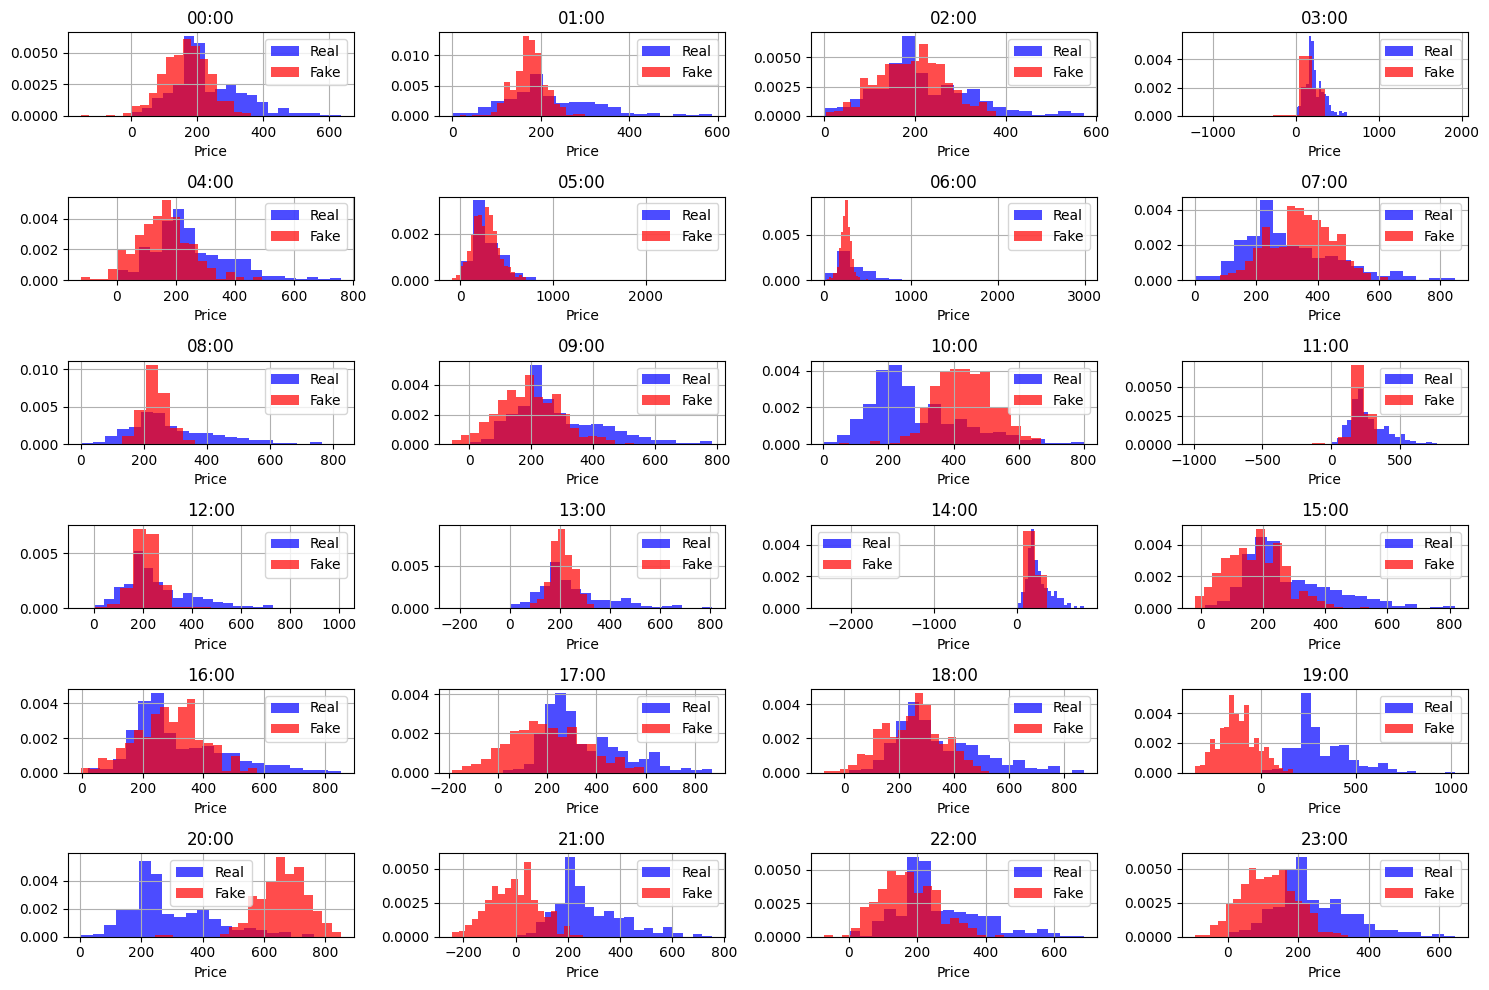

In [ ]:
# Create subplots
fig, axes = plt.subplots(6, 4, figsize=(15, 10))
axes = axes.flatten()

# Plot histograms for each hour
for idx in range(HoursDay):
    # Real Data
    subset1 = data[Hour_values[idx]]
    ax = axes[idx]
    ax.hist(subset1, bins=20, alpha=0.7, density=True, color='blue', label='Real')

    # Fake Data
    subset2 = data_fake_DPM[Hour_values[idx]]
    ax.hist(subset2, bins=20, alpha=0.7, density=True, color='red', label='Fake')

    # Set titles and labels
    ax.set_title(f'{Hour_values[idx]}')
    ax.set_xlabel('Price')
    ax.grid(True)
    ax.legend()

# Remove any unused subplots
for ax in axes[HoursDay:]:
    fig.delaxes(ax)

# Adjust layout
plt.tight_layout()

plt.savefig(os.path.join(save_dir, "DPM_FR2022"), dpi=300, transparent=True)  # 300 DPI and transparent

# Show the plot
plt.show()

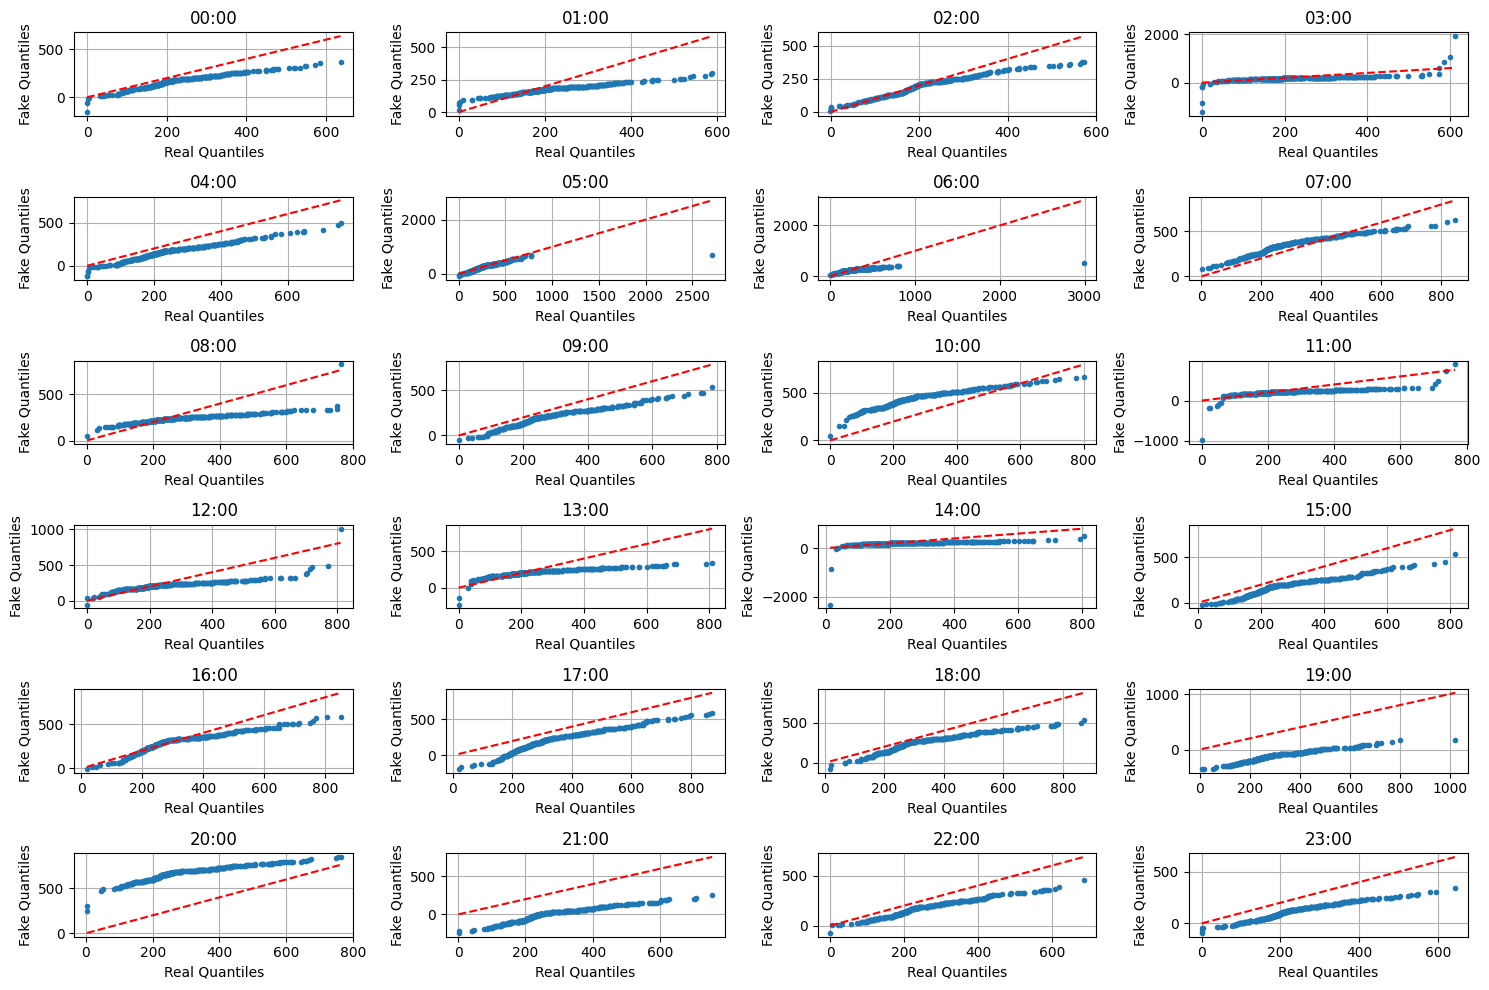

In [ ]:
# Create subplots
fig, axes = plt.subplots(6, 4, figsize=(15, 10))
axes = axes.flatten()

# Plot Q-Q plots for each hour
for idx in range(HoursDay):
    # Real Data
    subset1 = np.sort(data[Hour_values[idx]].to_numpy())
    # Fake Data
    subset2 = np.sort(data_fake_DPM[Hour_values[idx]].to_numpy())

    # Interpolate if sample sizes are unequal
    if len(subset1) != len(subset2):
        min_len = min(len(subset1), len(subset2))
        max_len = max(len(subset1), len(subset2))
        if len(subset1) == min_len:
            subset1 = np.interp(np.linspace(0, 1, max_len), np.linspace(0, 1, min_len), subset1)
        else:
            subset2 = np.interp(np.linspace(0, 1, max_len), np.linspace(0, 1, min_len), subset2)

    # Create Q-Q plot
    ax = axes[idx]
    ax.plot(subset1, subset2, 'o', markersize=3)
    ax.plot([min(subset1), max(subset1)], [min(subset1), max(subset1)], 'r--')  # Reference line
    ax.set_title(f'{Hour_values[idx]}')
    ax.set_xlabel('Real Quantiles')
    ax.set_ylabel('Fake Quantiles')
    ax.grid(True)

# Remove any unused subplots
for ax in axes[HoursDay:]:
    fig.delaxes(ax)

# Adjust layout
plt.tight_layout()

# Save the figure
save_path = os.path.join(save_dir, "DPM_QQPlots_FR2022.png")
plt.savefig(save_path, dpi=300, transparent=True)  # 300 DPI and transparent background

# Show the plot
plt.show()

In [ ]:
#CONTINUE HERE

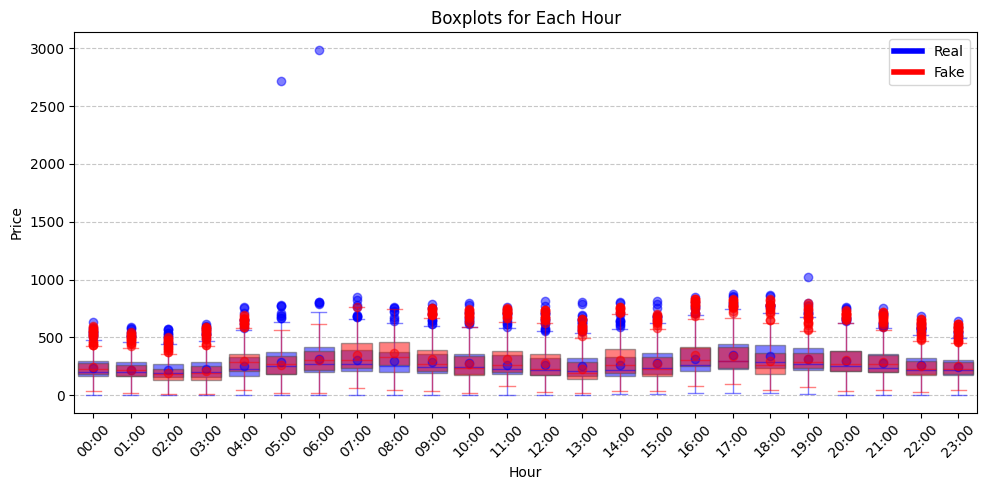

In [ ]:
melted_data = data[Hour_values].melt(var_name='Hour', value_name='Price')
melted_data_fake = data_fake[Hour_values].melt(var_name='Hour', value_name='Price')

# Plotting the boxplots
plt.figure(figsize=(10, 5))
# Plot the first dataset with transparency
ax = sns.boxplot(
    data=melted_data,
    x='Hour',
    y='Price',
    color='blue',
    dodge=False,
    showmeans=True,
    boxprops=dict(facecolor='blue', alpha=0.5),  # Set color and transparency for the box
    whiskerprops=dict(color='blue', alpha=0.5),  # Set color and transparency for the whiskers
    capprops=dict(color='blue', alpha=0.5),      # Set color and transparency for the caps
    medianprops=dict(color='blue', alpha=0.5),   # Set color and transparency for the median line
    meanprops=dict(marker='o', markerfacecolor='blue', markeredgecolor='blue', alpha=0.5),  # Set color and transparency for the mean marker
    flierprops=dict(marker='o', markerfacecolor='blue', markeredgecolor='blue', alpha=0.5)  # Set color and transparency for the outliers
)

# Plot the second dataset with transparency
sns.boxplot(
    data=melted_data_fake,
    x='Hour',
    y='Price',
    color='red',
    dodge=False,
    showmeans=True,
    boxprops=dict(facecolor='red', alpha=0.5),  # Set color and transparency for the box
    whiskerprops=dict(color='red', alpha=0.5),  # Set color and transparency for the whiskers
    capprops=dict(color='red', alpha=0.5),      # Set color and transparency for the caps
    medianprops=dict(color='red', alpha=0.5),   # Set color and transparency for the median line
    meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='red', alpha=0.5),  # Set color and transparency for the mean marker
    flierprops=dict(marker='o', markerfacecolor='red', markeredgecolor='red', alpha=0.5),  # Set color and transparency for the outliers
    ax=ax  # Plot on the same axes
)

# Adding labels for the legend
handles = [
    plt.Line2D([0], [0], color='blue', lw=4, label='Real'),
    plt.Line2D([0], [0], color='red', lw=4, label='Fake')
]
ax.legend(handles=handles)

# Customizing the plot
plt.xticks(rotation=45)
plt.xlabel("Hour")
plt.ylabel("Price")
plt.title("Boxplots for Each Hour")
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.show()

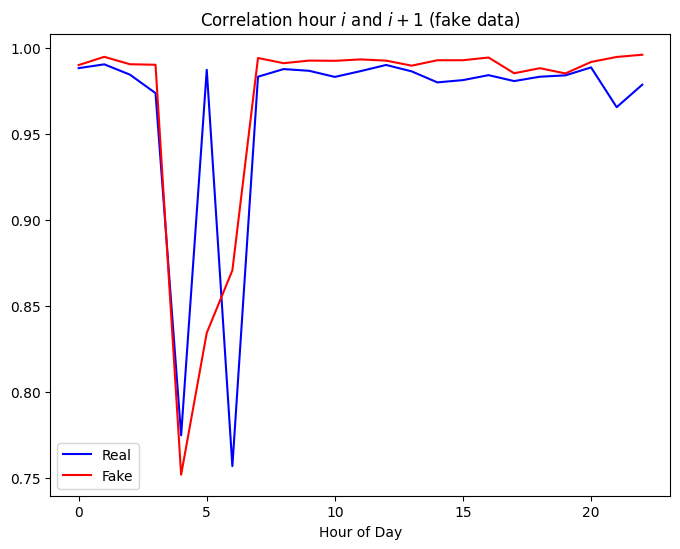

In [ ]:
correlations_real = []
for i in range((data[Hour_values]).shape[1] - 1):
    corr = (data[Hour_values]).iloc[:, i].corr((data[Hour_values]).iloc[:, i + 1])  # Correlation between column i and column i+1
    correlations_real.append(corr)

correlations_fake = []
for i in range((data_fake[Hour_values]).shape[1] - 1):
    corr = (data_fake[Hour_values]).iloc[:, i].corr((data_fake[Hour_values]).iloc[:, i + 1])  # Correlation between column i and column i+1
    correlations_fake.append(corr)

# Create the figure and axis
plt.figure(figsize=(8, 6))
plt.plot(correlations_real, color='blue', label='Real')
plt.plot(correlations_fake, color='red', label='Fake')
# Set labels for the axes
plt.xlabel('Hour of Day')
plt.legend()
plt.title(r'Correlation hour $i$ and $i+1$ (fake data)')

plt.show()

In [ ]:
pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 53.3 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp
from gurobipy import GRB

# Create an environment with your WLS license
params = {
"WLSACCESSID": '95e42e10-df92-4107-afd7-808c5911bdf2',
"WLSSECRET": 'dd2b6046-77c5-4479-8431-c85b31879b87',
"LICENSEID": 2537920,
}
Myenv = gp.Env(params=params)
Myenv.setParam('OutputFlag', 0)

#Compute the revenues per day for a given price
def storage_const_price(HoursDay,price,qmin = -1, qmax = 1, Qmin = 0, Qmax = 5., env=Myenv):
    m = gp.Model("const_price", env=env)
    T = HoursDay
    varlist = []
    for i in range(T):
        varlist.append(m.addVar(lb=qmin, ub=qmax, vtype=GRB.CONTINUOUS, name="q"+str(i)))
    Q0 = m.addVar(lb=Qmin,ub=Qmax,vtype = GRB.CONTINUOUS, name = "Q0")
    cons = gp.LinExpr()
    obj = gp.LinExpr()
    for i in range(T):
        cons+=varlist[i]
        obj+=price[i]*varlist[i]
        m.addConstr(Q0+cons>=Qmin)
        m.addConstr(Q0+cons<=Qmax)
    m.addConstr(cons==0)
    m.setObjective(obj, GRB.MINIMIZE)

    m.optimize()

    status = 1 if m.Status == gp.GRB.OPTIMAL else 0

    res = np.zeros(T)
    for i in range(T):
      res[i] = varlist[i].X

    return m.ObjVal, Q0.X, res[:], status

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2537920
Academic license 2537920 - for non-commercial use only - registered to ju___@gmail.com


In [ ]:
objective_values = []
initial_storage_levels = []
hourly_transactions = []
status_v = []

# Iterate over each day's Real prices
for counter, daily_prices in enumerate(Initial_data, start=1): #Initial_data is the np array with the initial dataset
    print(f"Entry {counter}/{Training_data.shape[0]}",end='r')

    obj_val, Q0, transactions, status = storage_const_price(HoursDay, price=daily_prices)

    objective_values.append(obj_val)
    initial_storage_levels.append(Q0)
    hourly_transactions.append(transactions)
    status_v.append(status)

objective_values = np.array(objective_values)
initial_storage_levels = np.array(initial_storage_levels)
hourly_transactions = np.array(hourly_transactions)
status_v = np.array(status_v)

print(np.sum(status_v))

Entry 1/365rEntry 2/365rEntry 3/365rEntry 4/365rEntry 5/365rEntry 6/365rEntry 7/365rEntry 8/365rEntry 9/365rEntry 10/365rEntry 11/365rEntry 12/365rEntry 13/365rEntry 14/365rEntry 15/365rEntry 16/365rEntry 17/365rEntry 18/365rEntry 19/365rEntry 20/365rEntry 21/365rEntry 22/365rEntry 23/365rEntry 24/365rEntry 25/365rEntry 26/365rEntry 27/365rEntry 28/365rEntry 29/365rEntry 30/365rEntry 31/365rEntry 32/365rEntry 33/365rEntry 34/365rEntry 35/365rEntry 36/365rEntry 37/365rEntry 38/365rEntry 39/365rEntry 40/365rEntry 41/365rEntry 42/365rEntry 43/365rEntry 44/365rEntry 45/365rEntry 46/365rEntry 47/365rEntry 48/365rEntry 49/365rEntry 50/365rEntry 51/365rEntry 52/365rEntry 53/365rEntry 54/365rEntry 55/365rEntry 56/365rEntry 57/365rEntry 58/365rEntry 59/365rEntry 60/365rEntry 61/365rEntry 62/365rEntry 63/365rEntry 64/365rEntry 65/365rEntry 66/365rEntry 67/365rEntry 68/365rEntry 69/365rEntry 70/365rEntry 71/365rEntry 72/365rEntry 73/365rEntry 74/365rEntry 75/365rEntry 76/365rEntry 77/365rEntry 78

In [ ]:
objective_values_fake = []
initial_storage_levels_fake = []
hourly_transactions_fake = []
status_v_fake = []

# Iterate over each day's Fake prices
for counter, daily_prices in enumerate(denormalized_array, start=1): #denormalized_array is the np array with the Fake dataset
    print(f"Entry {counter}/{denormalized_array.shape[0]}",end='r')

    obj_val, Q0, transactions, status = storage_const_price(HoursDay, price=daily_prices)

    objective_values_fake.append(obj_val)
    initial_storage_levels_fake.append(Q0)
    hourly_transactions_fake.append(transactions)
    status_v_fake.append(status)

objective_values_fake = np.array(objective_values_fake)
initial_storage_levels_fake = np.array(initial_storage_levels_fake)
hourly_transactions_fake = np.array(hourly_transactions_fake)
status_v_fake = np.array(status_v_fake)

Entry 1/365rEntry 2/365rEntry 3/365rEntry 4/365rEntry 5/365rEntry 6/365rEntry 7/365rEntry 8/365rEntry 9/365rEntry 10/365rEntry 11/365rEntry 12/365rEntry 13/365rEntry 14/365rEntry 15/365rEntry 16/365rEntry 17/365rEntry 18/365rEntry 19/365rEntry 20/365rEntry 21/365rEntry 22/365rEntry 23/365rEntry 24/365rEntry 25/365rEntry 26/365rEntry 27/365rEntry 28/365rEntry 29/365rEntry 30/365rEntry 31/365rEntry 32/365rEntry 33/365rEntry 34/365rEntry 35/365rEntry 36/365rEntry 37/365rEntry 38/365rEntry 39/365rEntry 40/365rEntry 41/365rEntry 42/365rEntry 43/365rEntry 44/365rEntry 45/365rEntry 46/365rEntry 47/365rEntry 48/365rEntry 49/365rEntry 50/365rEntry 51/365rEntry 52/365rEntry 53/365rEntry 54/365rEntry 55/365rEntry 56/365rEntry 57/365rEntry 58/365rEntry 59/365rEntry 60/365rEntry 61/365rEntry 62/365rEntry 63/365rEntry 64/365rEntry 65/365rEntry 66/365rEntry 67/365rEntry 68/365rEntry 69/365rEntry 70/365rEntry 71/365rEntry 72/365rEntry 73/365rEntry 74/365rEntry 75/365rEntry 76/365rEntry 77/365rEntry 78

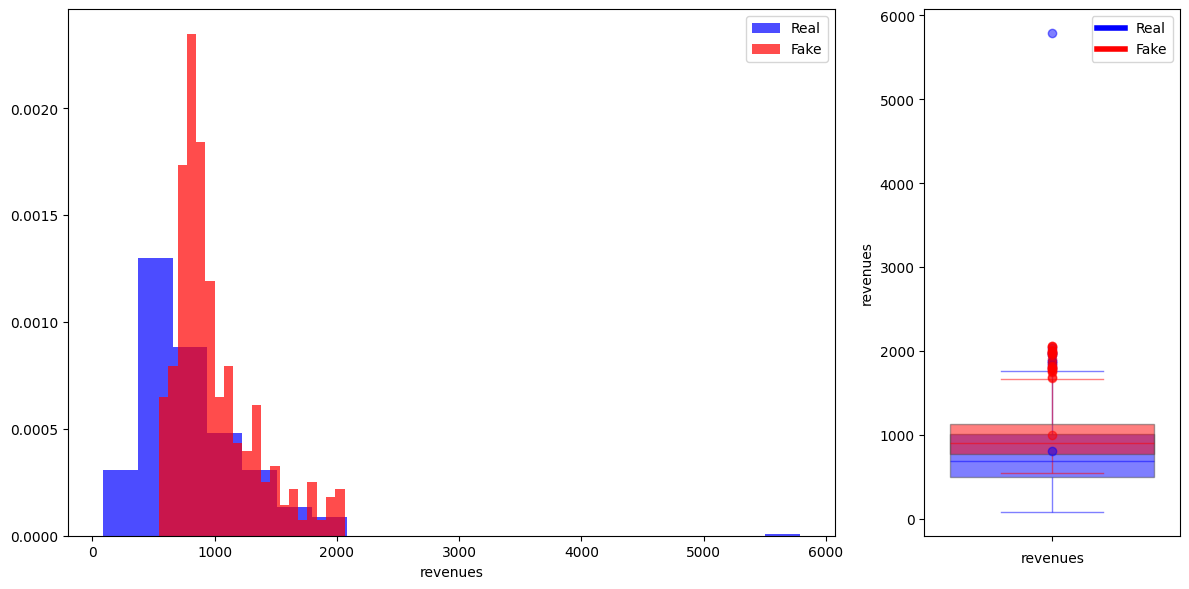

In [ ]:
revenues_normalized = (-objective_values - (-objective_values).min())/((-objective_values).max() - (-objective_values).min())

revenues = pd.DataFrame(data=-objective_values, columns=['revenues'])
revenues_normalized = pd.DataFrame(data=revenues_normalized, columns=['revenues_normalized'])

revenues_fake = pd.DataFrame(data=-objective_values_fake, columns=['revenues'])

# Create a figure with two subplots
fig, (ax_hist, ax_box) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})
# Plot histogram
ax_hist.hist(revenues['revenues'], bins=20, alpha=0.7, density=True, color='blue',label='Real')
ax_hist.hist(revenues_fake['revenues'], bins=20, alpha=0.7, density=True, color='red',label='Fake')
ax_hist.set_xlabel('revenues')
ax_hist.legend()

# Plot boxplot
ax_box = sns.boxplot(
    y=revenues['revenues'],
    color='blue',
    dodge=False,
    showmeans=True,
    boxprops=dict(facecolor='blue', alpha=0.5),  # Set color and transparency for the box
    whiskerprops=dict(color='blue', alpha=0.5),  # Set color and transparency for the whiskers
    capprops=dict(color='blue', alpha=0.5),      # Set color and transparency for the caps
    medianprops=dict(color='blue', alpha=0.5),   # Set color and transparency for the median line
    meanprops=dict(marker='o', markerfacecolor='blue', markeredgecolor='blue', alpha=0.5),  # Set color and transparency for the mean marker
    flierprops=dict(marker='o', markerfacecolor='blue', markeredgecolor='blue', alpha=0.5)  # Set color and transparency for the outliers
)
ax_box = sns.boxplot(
    y=revenues_fake['revenues'],
    color='red',
    dodge=False,
    showmeans=True,
    boxprops=dict(facecolor='red', alpha=0.5),  # Set color and transparency for the box
    whiskerprops=dict(color='red', alpha=0.5),  # Set color and transparency for the whiskers
    capprops=dict(color='red', alpha=0.5),      # Set color and transparency for the caps
    medianprops=dict(color='red', alpha=0.5),   # Set color and transparency for the median line
    meanprops=dict(marker='o', markerfacecolor='red', markeredgecolor='red', alpha=0.5),  # Set color and transparency for the mean marker
    flierprops=dict(marker='o', markerfacecolor='red', markeredgecolor='red', alpha=0.5)  # Set color and transparency for the outliers
)
ax_box.set_xlabel('revenues')
# Adding labels for the legend
handles = [
    plt.Line2D([0], [0], color='blue', lw=4, label='Real'),
    plt.Line2D([0], [0], color='red', lw=4, label='Fake')
]
ax_box.legend(handles=handles)
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

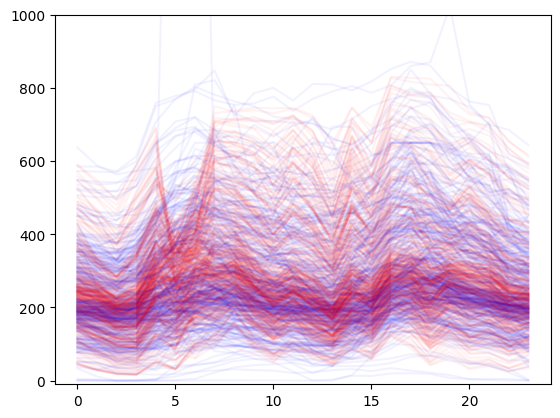

In [ ]:
for i in range(len(denormalized_array)):
  plt.plot(denormalized_array[i],color='red',alpha=0.05)
  plt.plot((data[Hour_values].values)[i],color='blue',alpha=0.05)
  plt.ylim(-10,1000)
plt.show()


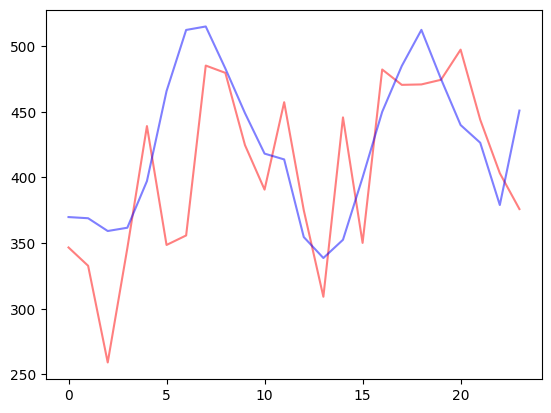

In [ ]:
plt.plot(denormalized_array[34],color='red',alpha=0.5)
plt.plot((data[Hour_values].values)[65],color='blue',alpha=0.5)
plt.show()